# Processing pipeline

In [85]:
import sys
sys.path.insert(1, '/Users/lauradellantonio/neuefische/Capstone/capstone')
import warnings

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tidy_functions.load_data
import tidy_functions.clean_data
import tidy_functions.merge_data_model
import tidy_functions.feature_engineering

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None) # To display all columns

## Read in data

In [27]:
# Reading in survey data from csv into a dictionary of dataframes.
dfs_country = tidy_functions.load_data.load_survey_data("/Users/lauradellantonio/neuefische/Capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")

# Concatenating individuals dataframes from the dictionary into one dataframe for regions.
survey_data = pd.concat(dfs_country, ignore_index=True)

# Corona stats
covid_cases = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/corona_stats_14days.csv")
print('Read in covid data completed.')

# Mask wearing requirements
mask_wearing_requirements = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/data-nbhtq.csv")
print('Read in mask wearing requirements data completed.')

Read in survey data completed.
Read in covid data completed.
Read in mask wearing requirements data completed.


## Cleaning data

In [28]:
# Survey data
survey_data = tidy_functions.clean_data.delete_other_gender(survey_data)
survey_data = tidy_functions.clean_data.deal_with_NaNs_masks(survey_data)

# Corona stats
covid_cases = tidy_functions.clean_data.deal_with_NaNs_corona_stats(covid_cases)

# Mask wearing requirements
mask_wearing_requirements = tidy_functions.clean_data.prepare_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_public_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_indoors_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_transport_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.data_types_mask_req(mask_wearing_requirements)

# HDI
hdi_data = tidy_functions.clean_data.rename_hdi_countries("/Users/lauradellantonio/neuefische/Capstone/capstone/data/","hdro_statistical_data_tables_1_15_d1_d5.xlsx")
dict_hdi = tidy_functions.clean_data.create_hdi_dict(hdi_data)
dict_hdi_levels = tidy_functions.clean_data.create_hdi_levels_dict(hdi_data)

NaNs before update: 152923
NaNs after update: 0
Updated NaNs in wear_mask_all_time.
NaNs removed.
Step 1 of cleaning requirements completed.
Step 2 of cleaning requirements completed.
Step 3 of cleaning requirements completed.
Step 4 of cleaning requirements completed.
Step 5 of cleaning requirements completed.
Step 6 of cleaning requirements completed.
Creating dictionaries for hdi completed.
Creating dictionaries for hdi-levels completed.


## Merging data

In [29]:
covid_merge = tidy_functions.merge_data_model.merge_corona_stats(survey_data,covid_cases)
requirements_merge = tidy_functions.merge_data_model.merge_mask_req(covid_merge,mask_wearing_requirements)
hdi_merge = tidy_functions.merge_data_model.create_hdi_columns(requirements_merge, dict_hdi, dict_hdi_levels)

Merging corona stats completed.
Merging mask wearing requirements completed.
Creating hdi list completed.
Creating hdi-level list completed.


## Feature engineering

In [30]:
date_fixed = tidy_functions.feature_engineering.insert_month(hdi_merge)
requirement_date = tidy_functions.feature_engineering.add_requirement_by_date(date_fixed)

Month column created.
Feature engineering completed.


In [31]:
df = requirement_date.copy()

In [32]:
df = df[df["age_bucket"]=="overall"]
df = df[df["gender"]=="overall"]

In [33]:
date = ["date"]

columns_general = ["iso_code", "hdi", "median_age"]

columns_general_no_iso = ["hdi", "median_age"]

columns_social_distancing = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted"]

columns_mask_wearing = ["smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted"]

columns_mask_req = ["cur_mask_recommended", "cur_mask_not_required", "cur_mask_not_required_recommended", "cur_mask_not_required_universal", 
                    "cur_mask_required_part_country", "cur_mask_everywhere_in_public", "cur_mask_public_indoors", "cur_mask_public_transport"]

columns_past = ["total_cases_per_million","previous_7days"]

columns_pred = ["next_14days"]

columns_interest = date + columns_general + columns_social_distancing + columns_mask_wearing + columns_mask_req + columns_past + columns_pred


In [34]:
df_select = df[columns_interest]

In [35]:
df_time = df_select.copy()

In [36]:
df_time.previous_7days = pd.to_numeric(df_time.previous_7days, errors='coerce')
df_time.next_14days = pd.to_numeric(df_time.next_14days, errors='coerce')

In [37]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21270 entries, 5 to 218776
Data columns (total 24 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   date                                              21270 non-null  datetime64[ns]
 1   iso_code                                          21270 non-null  object        
 2   hdi                                               21270 non-null  float64       
 3   median_age                                        21270 non-null  float64       
 4   smoothed_pct_worked_outside_home_weighted         21270 non-null  float64       
 5   smoothed_pct_grocery_outside_home_weighted        21270 non-null  float64       
 6   smoothed_pct_ate_outside_home_weighted            21270 non-null  float64       
 7   smoothed_pct_attended_public_event_weighted       21270 non-null  float64       
 8   smoothed_pct_used_public_

In [38]:
df_time = df_time.sort_values('date')

In [39]:
df_no_iso = df_time.drop("iso_code", axis=1)
df_no_date = df_no_iso.drop("date", axis=1)

In [40]:
#divide the data into train and test data
train_size = int(len(df_no_date) * 0.80)
test_size = len(df_no_date) - train_size
train, test = df_no_date[0:train_size], df_no_date[train_size:len(df_no_date)]

In [41]:
#index the data into dependent and independent variables
train_X, train_y = train.drop("next_14days", axis=1), train["next_14days"]
test_X, test_y =  test.drop("next_14days", axis=1), test["next_14days"]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17016, 21) (17016,) (4254, 21) (4254,)


In [42]:
#to_scale = ["median_age", "smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", 
#            "smoothed_pct_ate_outside_home_weighted", "smoothed_pct_attended_public_event_weighted", 
#            "smoothed_pct_used_public_transit_weighted", "smoothed_pct_direct_contact_with_non_hh_weighted", 
#            "smoothed_pct_no_public_weighted", "smoothed_pct_wear_mask_all_time_weighted", 
#            "smoothed_pct_wear_mask_most_time_weighted", "previous_day","previous_7days","previous_30days"]

In [43]:
#scale the values
#scaler_X = MinMaxScaler()
#train_X[to_scale] = scaler_X.fit_transform(train_X[to_scale])
#test_X[to_scale] = scaler_X.transform(test_X[to_scale])

In [44]:
#scaler_y = MinMaxScaler()
#scaler_y.fit(train_y)
#train_y = scaler_y.fit_transform(train_y)
#test_y = scaler_y.transform(test_y)

In [45]:
model = RandomForestRegressor(criterion='mae')

In [46]:
# define the target transform wrapper 
wrapped_model = TransformedTargetRegressor(regressor=model,transformer=MinMaxScaler()) 
# use the target transform wrapper 
wrapped_model.fit(train_X, train_y) 
yhat = wrapped_model.predict(test_X)

In [47]:
metrics.mean_absolute_error(test_y, yhat)

1133.6785336483304

In [50]:
df_no_date.next_14days.mean()

4519.979260366714

In [51]:
1122/4519*100

24.828501880947112

## Regular train test split

In [66]:
# X and y
X = df_no_date.drop("next_14days", axis=1)
y = df_no_date["next_14days"]

In [67]:
#divide the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17016, 21) (4254, 21) (17016,) (4254,)


In [69]:
model = RandomForestRegressor(criterion='mae')

In [71]:
# define the target transform wrapper 
wrapped_model = TransformedTargetRegressor(regressor=model,transformer=MinMaxScaler()) 
# use the target transform wrapper 
wrapped_model.fit(X_train, y_train) 
y_pred = wrapped_model.predict(X_test)

In [72]:
metrics.mean_absolute_error(y_test, y_pred)

107.57625257522336

In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [77]:
mean_absolute_percentage_error(y_test, y_pred)

3.7252358313838796

https://www.scikit-yb.org/en/latest/api/regressor/residuals.htmlmean_absolute_percentage_error

## Yellowbrick

In [59]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import residuals_plot


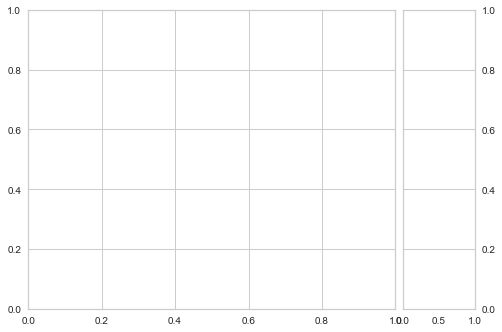

In [54]:
visualizer = ResidualsPlot(wrapped_model.regressor_)

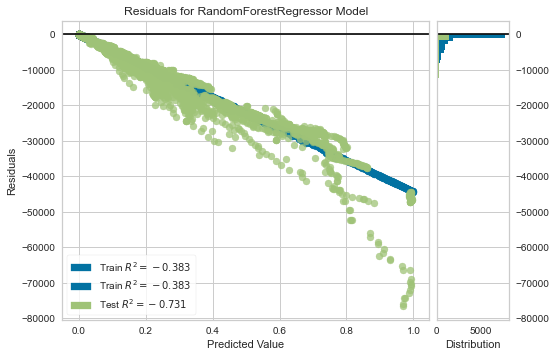

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [57]:
visualizer.fit(train_X, train_y)  # Fit the training data to the visualizer
visualizer.score(test_X, test_y)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

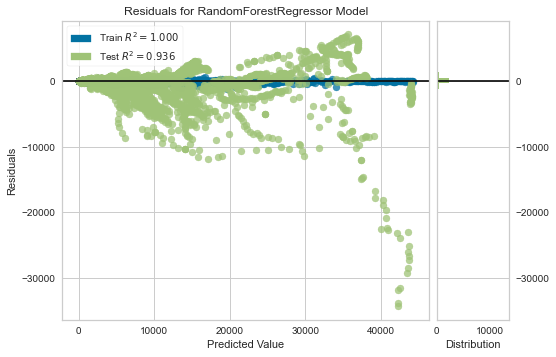

In [60]:
viz = residuals_plot(RandomForestRegressor(), train_X, train_y, test_X, test_y)

In [61]:
model2 = RandomForestRegressor(criterion='mae')

In [62]:
wrapped_model2 = TransformedTargetRegressor(regressor=model2,transformer=MinMaxScaler()) 

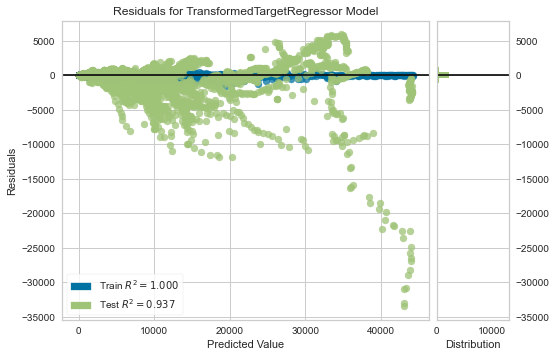

In [64]:
viz = residuals_plot(wrapped_model2, train_X, train_y, test_X, test_y)

### With normal test train split

In [73]:
model3 = RandomForestRegressor(criterion='mae')

In [74]:
wrapped_model3 = TransformedTargetRegressor(regressor=model3,transformer=MinMaxScaler()) 

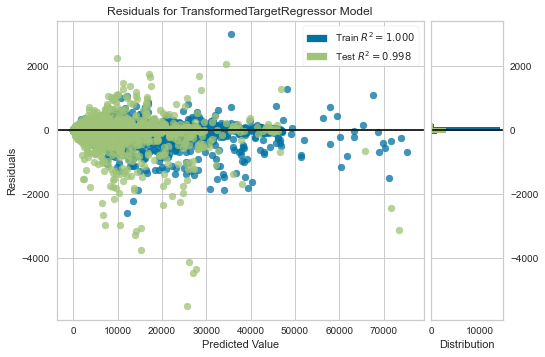

In [75]:
viz = residuals_plot(wrapped_model3, X_train, y_train, X_test, y_test)

## Partial dependency plots

In [78]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [82]:
features = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted", "smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted"]

<Figure size 2160x2160 with 0 Axes>

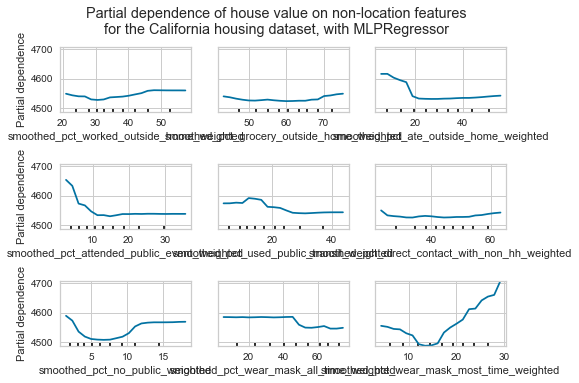

In [89]:
plt.figure(figsize = (30,30))
plot_partial_dependence(wrapped_model, X_train, features,
                        n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
fig.subplots_adjust(hspace=0.8)
